<a href="https://colab.research.google.com/github/ZZnvm/ENVSCI-794_Zihao/blob/main/VRP_iteration3.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>


# VRP on Real Roads (Auckland)

This notebook solves a simple **Vehicle Routing Problem** (one vehicle) over real **OSM** road data using:
- **OSMnx** + **NetworkX** to build a drivable road graph and compute shortest paths,
- **PyVRP** to optimise the visit order (distance = road length), and
- **Folium** to export an **interactive HTML map** of the final route.

**Input:** `/content/test_data.xlsx` where the **first row** is the **depot** and the remaining rows are **customers**. Columns can be `lon/lat` or `X/Y` (`X≈lat`, `Y≈lon`).

> For travel-time optimisation later, swap `weight="length"` for `weight="travel_time"` after adding OSMnx edge speeds.


In [ ]:
%pip install -q osmnx pyvrp folium openpyxl
# Step 0: Imports & configuration
import os
import numpy as np
import pandas as pd
import networkx as nx
import osmnx as ox
import folium

from pyvrp import Model, solve
from pyvrp.stop import MaxIterations

EXCEL_PATH = "/content/test_data.xlsx"   # change if needed
GRAPH_RADIUS_M = 6000                     # road graph radius around depot (meters)


## Step 1 — Load depot & customer points

In [ ]:

def load_lon_lat(excel_path: str):
    df = pd.read_excel(excel_path)
    cols = {c.lower(): c for c in df.columns}
    # try standard names first
    if "lon" in cols and "lat" in cols:
        lon = df[cols["lon"]].astype(float).to_numpy()
        lat = df[cols["lat"]].astype(float).to_numpy()
    elif "longitude" in cols and "latitude" in cols:
        lon = df[cols["longitude"]].astype(float).to_numpy()
        lat = df[cols["latitude"]].astype(float).to_numpy()
    elif "x" in cols and "y" in cols:
        X = df[cols["x"]].astype(float).to_numpy()
        Y = df[cols["y"]].astype(float).to_numpy()
        # Heuristic: X≈lat, Y≈lon (matches user's screenshot)
        if np.nanmax(np.abs(X)) <= 90 and np.nanmax(np.abs(Y)) <= 180:
            lon, lat = Y, X
        else:
            lon, lat = X, Y
    else:
        raise ValueError("Could not infer lon/lat columns. Expected (lon, lat) or (X, Y).")
    return lon, lat

lons, lats = load_lon_lat(EXCEL_PATH)
if len(lons) < 2:
    raise ValueError("Need at least 1 depot + 1 customer in the spreadsheet.")

depot_lon, depot_lat = float(lons[0]), float(lats[0])
cust_lons = lons[1:]
cust_lats = lats[1:]
print("Depot:", depot_lat, depot_lon, "| Customers:", len(cust_lons))


Depot: -36.8535 174.7684 | Customers: 20


## Step 2 — Build a drivable OSM road graph near the depot

In [ ]:

G = ox.graph_from_point((depot_lat, depot_lon), dist=GRAPH_RADIUS_M, network_type="drive", simplify=True)
print("Graph nodes:", len(G.nodes), "edges:", len(G.edges))


Graph nodes: 5264 edges: 12205


## Step 3 — Snap all points to the graph

In [ ]:

depot_node = ox.distance.nearest_nodes(G, X=depot_lon, Y=depot_lat)
cust_nodes = ox.distance.nearest_nodes(G, X=cust_lons, Y=cust_lats)
nodes_all = [depot_node] + list(cust_nodes)  # order we'll use everywhere
N = len(nodes_all)
N


21

## Step 4 — Build a road-distance (meters) matrix using shortest paths

In [ ]:

def dist_from_source(graph, src):
    # dict: node -> shortest-path length (meters) on the graph
    return nx.shortest_path_length(graph, source=src, weight="length")

dist_cache = {n: dist_from_source(G, n) for n in nodes_all}
cost = np.zeros((N, N), dtype=np.int64)
for i, u in enumerate(nodes_all):
    for j, v in enumerate(nodes_all):
        if i == j:
            continue
        L = dist_cache[u].get(v, np.inf)
        if np.isinf(L):
            # fallback: great-circle meters (should be rare in urban graphs)
            L = ox.distance.great_circle_vec(G.nodes[u]['y'], G.nodes[u]['x'],
                                             G.nodes[v]['y'], G.nodes[v]['x'])
        cost[i, j] = int(round(L))

cost[:5, :5]


array([[   0,  684, 1400, 1803, 1886],
       [ 684,    0, 1486, 2177, 2333],
       [7710, 7862,    0, 6410, 6933],
       [1642, 2060, 2319,    0,  543],
       [1722, 2178, 2399,  665,    0]])

## Step 5 — Build & solve the VRP (PyVRP, 1 vehicle, no capacity)

In [ ]:

model = Model()

# Add locations and store their *PyVRP IDs* (not OSM ids)
depot_id = model.add_depot(x=0, y=0)
client_ids = []
for _ in range(1, N):
    cid = model.add_client(x=0, y=0, service_duration=0)
    client_ids.append(cid)

loc_ids = [depot_id] + client_ids

# Profile with edges using location IDs
prof = model.add_profile(name="road_len")
for i in range(N):
    for j in range(N):
        if i != j:
            d = int(cost[i, j])
            prof.add_edge(loc_ids[i], loc_ids[j], distance=d, duration=d)

# One vehicle starting/ending at depot
model.add_vehicle_type(num_available=1, start_depot=depot_id, end_depot=depot_id, profile=prof)

# Solve (support older/newer API variants)
try:
    res = solve(model, stop=MaxIterations(10_000))
except AttributeError:
    data = model.to_data() if hasattr(model, "to_data") else model.data()
    res = solve(data, stop=MaxIterations(10_000))

best = res.best
route = next(iter(best.routes()))
seq = [route.start_depot()] + route.visits() + [route.end_depot()]
print("Visit order (indices):", seq)


Visit order (indices): [0, 20, 6, 16, 13, 3, 4, 19, 10, 9, 12, 18, 1, 7, 11, 15, 8, 2, 14, 17, 5, 0]


## Step 6 — Rebuild road paths for the solved visit order

In [ ]:

paths = []
for a, b in zip(seq[:-1], seq[1:]):
    u, v = nodes_all[a], nodes_all[b]
    p = nx.shortest_path(G, u, v, weight="length")
    paths.append(p)

# Build continuous node list without duplicate stitch nodes
route_nodes = []
for i, p in enumerate(paths):
    route_nodes.extend(p if i == 0 else p[1:])

len(route_nodes)


132

## Step 7 — Make an interactive Folium map

In [ ]:

# Center on depot
center_lat, center_lon = G.nodes[nodes_all[0]]["y"], G.nodes[nodes_all[0]]["x"]
m = folium.Map(location=[center_lat, center_lon], zoom_start=14, tiles="OpenStreetMap")

# Route polyline
route_latlon = [(G.nodes[n]["y"], G.nodes[n]["x"]) for n in route_nodes]
folium.PolyLine(route_latlon, weight=5, opacity=0.9, tooltip="Optimized route").add_to(m)

# Depot + customers
for i, osm_id in enumerate(nodes_all):
    lat, lon = G.nodes[osm_id]["y"], G.nodes[osm_id]["x"]
    if i == 0:
        folium.Marker([lat, lon], icon=folium.Icon(color="green", icon="star"),
                      tooltip="Depot (0)", popup=f"Depot (0)\n({lat:.6f}, {lon:.6f})").add_to(m)
    else:
        folium.CircleMarker([lat, lon], radius=5, fill=True, fill_opacity=0.9,
                            tooltip=f"Customer {i}", popup=f"Customer {i}\n({lat:.6f}, {lon:.6f})").add_to(m)
        folium.Marker([lat, lon], icon=folium.DivIcon(html=f'<div style="font-size:10px;color:#111">{i}</div>')).add_to(m)

# Save map
html_out = "/content/vrp_route_map.html"
m.save(html_out)
# Display
m



NameError: name 'plt' is not defined

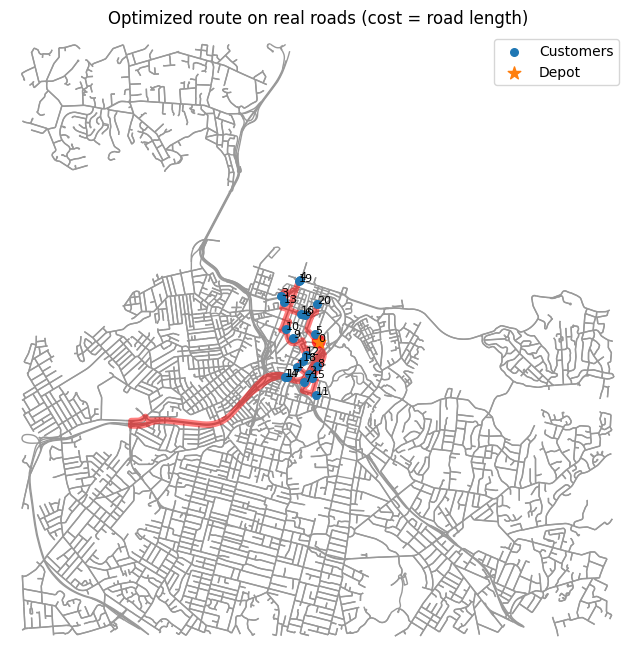

In [ ]:
# build a single node sequence without self-loop pairs
route_nodes = []
for i, p in enumerate(paths):
    if i == 0:
        route_nodes.extend(p)
    else:
        route_nodes.extend(p[1:])  # drop the first node (same as previous segment's last)

fig, ax = ox.plot_graph_routes(
    G,
    routes=[route_nodes],
    route_linewidth=3,
    node_size=0,
    bgcolor="white",
    show=False,
    close=False,
)

# points/labels as before
xs = [G.nodes[n]['x'] for n in nodes_all]
ys = [G.nodes[n]['y'] for n in nodes_all]
ax.scatter(xs[1:], ys[1:], s=30, zorder=5, label="Customers")
ax.scatter(xs[0], ys[0], s=90, marker="*", zorder=6, label="Depot")
for i, (x, y) in enumerate(zip(xs, ys)):
    ax.text(x, y, str(i), fontsize=8, zorder=7)

ax.legend()
ax.set_title("Optimized route on real roads (cost = road length)")
plt.show()
